# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

EPSG:31370
EPSG:4326
Площа області:           square
2  169871.495051
Загальна довжина доріг у області 3: 6911.73 км
Знайдено 262 точок у області '3'
[(515754.4322585854, 5711849.281087554), (521844.0098370353, 5723799.892860873), (521899.4678665459, 5723639.656284934), (548795.0521834574, 5754553.015432733), (555184.7216784665, 5766020.395995758), (555208.7252244834, 5765958.837643246), (555610.9259812151, 5766326.991592901), (555875.2993724633, 5759906.463270777), (556417.6097045183, 5760036.642564815), (557953.1761819704, 5758905.219709567), (558339.728051856, 5762258.748045991), (558618.7848836925, 5761711.426013414), (558733.7396327406, 5761618.583519779), (664340.7109421986, 5914237.527473611), (664544.3784386829, 5914443.152338433), (667457.9908102741, 5921833.015763325), (668584.8224909473, 5922187.862430762), (668584.5294419851, 5922188.620379951), (674347.3885611608, 5914257.873016171), (675054.9415321002, 5914350.70324075), (675517.3825172608, 5914111.024112069), (676602.142

C:\Users\silim\AppData\Local\Temp\ipykernel_5272\2906238418.py:116: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


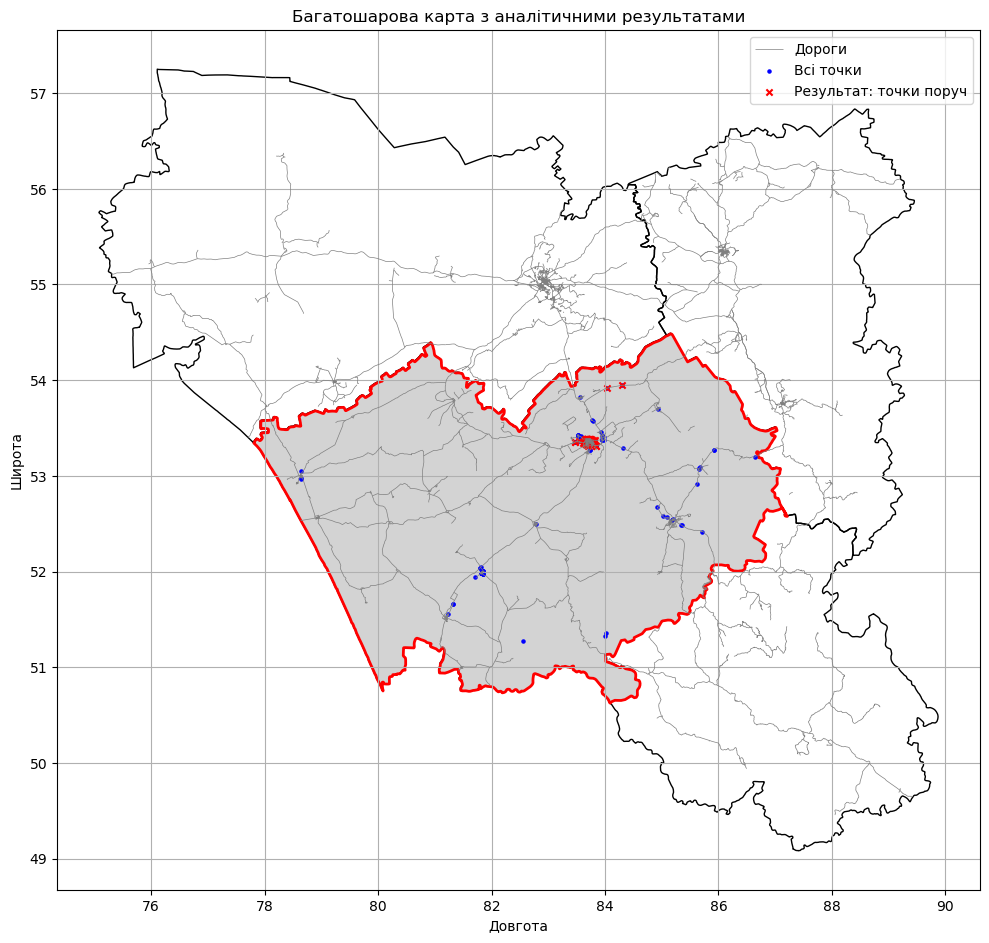

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt



def calculate_square_of_area(gdf, region_num):
    region = gdf.iloc[[region_num-1]]
    if not region.empty:
        region = region.to_crs(epsg=32644).copy()
        region["square"] = region.geometry.area / 10 ** 6
        print(f"Площа області: {region[["square"]]}")
    else:
        raise Exception("Територія не має такої області")


def calculate_roads_length(gdf, gdf2, region_num):
    # Витягуємо регіон і дороги в окремі змінні
    region = gdf.iloc[[region_num - 1]].copy()

    region = region.to_crs(epsg=32644)
    roads = gdf2.to_crs(epsg=32644)

    # Вирізаємо дороги в межах регіону
    roads_in_region = gpd.clip(roads, region)

    # Обчислюємо довжину в кілометрах
    roads_in_region["length"] = roads_in_region.geometry.length / 1000
    total_sum = roads_in_region["length"].sum()

    print(f"Загальна довжина доріг у області {region_num}: {total_sum:.2f} км")
    return roads_in_region


def filter_points(points_gdf, admin_gdf, region_num):
    region = admin_gdf.iloc[[region_num-1]]
    region = region.to_crs(epsg=32644)
    points_gdf = points_gdf.to_crs(epsg=32644)

    points_in_region = gpd.sjoin(points_gdf, region, predicate='within')



    # 4. Вивести координати точок
    coords = points_in_region.geometry.apply(lambda geom: (geom.x, geom.y))

    print(f"Знайдено {len(points_in_region)} точок у області '{region_num}'")
    print(coords.to_list())

    return points_in_region


def find_points_near_object(admin_gdf, region_num, points_gdf, object_gdf, object_filter, buffer_distance_km):
    # 1. Відфільтрувати об’єкт
    for key, value in object_filter.items():
        object_gdf = object_gdf[object_gdf[key] == value]

    if object_gdf.empty:
        print("Об'єкт не знайдено.")
        return

    region_gdf = admin_gdf.iloc[[region_num-1]]
    # 2. Встановити спільну CRS і перевести до метричної (наприклад, UTM zone 44N — EPSG:32644)
    points_proj = points_gdf.to_crs(epsg=32644)
    object_proj = object_gdf.to_crs(epsg=32644)
    region_gdf = region_gdf.to_crs(epsg=32644)
    object_proj = gpd.clip(object_proj, region_gdf)
    # 3. Побудувати буфер
    buffer = object_proj.buffer(buffer_distance_km * 1000)

    # 4. Об'єднати всі геометрії буфера в один полігон
    buffer_union = buffer.union_all()

    # 5. Знайти точки в межах буфера
    points_near = points_proj[points_proj.geometry.within(buffer_union)]

    # 6. Повернути в WGS84 для координат
    points_near = points_near.to_crs(epsg=4326)

    # 7. Вивести координати
    coords = points_near.geometry.apply(lambda geom: (geom.x, geom.y))
    print(f"Знайдено {len(points_near)} точок в радіусі {buffer_distance_km} км:")
    print(coords.to_list())

    return points_near


def plot_multilayer_map(admin_gdf, roads_gdf, points_gdf, result_points_gdf=None, region_num=None):
    # Встановлюємо CRS для всіх шарів
    admin_gdf = admin_gdf.to_crs(epsg=4326)
    roads_gdf = roads_gdf.to_crs(epsg=4326)
    points_gdf = points_gdf.to_crs(epsg=4326)
    if result_points_gdf is not None:
        result_points_gdf = result_points_gdf.to_crs(epsg=4326)

    fig, ax = plt.subplots(figsize=(10, 10))

    # 1. Адміністративні межі
    admin_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, label='Адміністративні межі')

    # Виділити конкретну область, якщо задано
    if region_num:
        region = admin_gdf.iloc[[region_num - 1]]
        region.plot(ax=ax, facecolor='lightgray', edgecolor='red', linewidth=2, label='Обрана область')

    # 2. Дороги
    roads_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Дороги')

    # 3. Всі точки
    points_gdf.plot(ax=ax, color='blue', markersize=5, label='Всі точки')

    # 4. Точки після аналітики (наприклад, ті, що в радіусі 5 км)
    if result_points_gdf is not None:
        result_points_gdf.plot(ax=ax, color='red', markersize=20, marker='x', label='Результат: точки поруч')

    # Додати легенду та сітку
    plt.legend()
    plt.title('Багатошарова карта з аналітичними результатами')
    plt.xlabel('Довгота')
    plt.ylabel('Широта')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    admin = gpd.read_file("./geosample-arcgis/shape/admin.shp", encoding='cp1251')
    roads = gpd.read_file("./geosample-arcgis/shape/road-l-osm.shp", encoding='cp1251')
    points = gpd.read_file("./geosample-arcgis/shape/poi-osm.shp", encoding='cp1251')

    #Перевірка на перевизначення проєкцій
    admin_crs = admin.to_crs(epsg=31370)
    print(admin_crs.crs)
    admin_converted = admin_crs.to_crs(epsg=4326)
    print(admin_converted.crs)

    #Номер адміністративної точки(ввести назву в консоль)
    area_name = int(input(f"Введіть номер області від 1 до 4:\n"))

    calculate_square_of_area(admin, area_name)

    roads_in_region = calculate_roads_length(admin,roads, area_name)

    points_in_region = filter_points(points, admin, area_name)

    points_near = find_points_near_object(admin, area_name, points, roads, {"TYPE": "primary"}, buffer_distance_km=5)

    plot_multilayer_map(admin, roads, points_in_region, result_points_gdf=points_near, region_num=area_name)


In [ ]:
5